In [53]:
import numpy as np
import librosa
import os
from os import walk
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
import datetime 
import pandas as pd

**Fonctions pour l'extraction du vecteur de 12 valeurs**

In [54]:
def get_chroma_vector(wav_file_path, target_duration=3):
    y, sr = librosa.load(wav_file_path, sr=None)
  
    chroma = np.array(librosa.feature.chroma_stft(y=y, sr=sr))
    df_chroma = pd.DataFrame(chroma)
    moyenne_par_colonne = df_chroma.mean()
    # Sélectionnez les colonnes dont la moyenne est inférieure ou égale à 0.6
    colonnes_a_conserver = moyenne_par_colonne[moyenne_par_colonne <= 0.65].index

    # Créez un nouveau DataFrame en ne conservant que les colonnes sélectionnées
    df_filtered = df_chroma[colonnes_a_conserver]
    new_chroma = df_filtered.to_numpy()
    return new_chroma

In [55]:
def normalize_pcp(pcp):
    total_energy = np.sum(pcp)
    normalized_pcp = pcp / total_energy
    return normalized_pcp

In [56]:
def get_feature(file_path):
 # Extracting chroma vector feature
  chroma = get_chroma_vector(file_path)
  #norm_chroma= normalize_pcp(chroma)
  chroma_mean = chroma.mean(axis=1)

  feature = chroma_mean
  return feature

**Creation du Dataset**

In [57]:
def extract_features(directory):
    features = []
    labels = []

    for root, dirs, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            feature = get_feature(file_path)
            label = file.split('_')[1].split('.')[0]
            features.append(feature)
            labels.append(label)

    return features, labels

In [58]:
def calculate_error(model, X, y):
    y_pred = model.predict(X)
    pred = []
    for i in range(len(y_pred)):
        pred.append(np.argmax(y_pred[i]))

    count = 0
    for i in range(len(pred)):
        if pred[i] == y[i]:
            count+=1

    return 100 - count/len(y)*100

Création de X et de y

In [59]:
dir = r"C:\Users\lucie\Documents\Programmation\PFE_Analayse_musicale\Chords_generation\chords_wav\clean"
featuresClean, labelsClean = extract_features(dir)

In [60]:
label_encoder = LabelEncoder()
labels_encodedC = label_encoder.fit_transform(labelsClean)

X_trainC, X_testC, y_trainC, y_testC = train_test_split(featuresClean, labels_encodedC, test_size=0.3,shuffle=True)
X_trainC = np.array(X_trainC)
X_testC = np.array(X_testC)

In [61]:
dir2 = r"C:\Users\lucie\Documents\Programmation\PFE_Analayse_musicale\Chords_generation\chords_wav\noisy"
featuresNoisy, labelsNoisy = extract_features(dir2)

In [62]:
label_encoder = LabelEncoder()
labels_encodedN = label_encoder.fit_transform(labelsNoisy)

X_trainN, X_testN, y_trainN, y_testN = train_test_split(featuresNoisy, labels_encodedN, test_size=0.3,shuffle=True)
X_trainN = np.array(X_trainN)
X_testN = np.array(X_testN)

In [63]:
X_A_train, X_A_remaining, y_A_train, y_A_remaining = train_test_split(featuresClean, labels_encodedC, train_size=350,shuffle=True)
X_B_train, X_B_remaining, y_B_train, y_B_remaining = train_test_split(featuresNoisy, labels_encodedN, train_size=350,shuffle=True)

# Étape 2 : Concaténez les échantillons extraits
X_trainB = np.concatenate((X_A_train, X_B_train), axis=0)
y_trainB = np.concatenate((y_A_train, y_B_train), axis=0)

Différents modèles

In [64]:
modelMomentum0 = keras.Sequential()
modelMomentum0.add(keras.layers.Input(shape=(12,)))
modelMomentum0.add(keras.layers.Dense(35, activation='relu'))
modelMomentum0.add(keras.layers.Dense(10, activation='softmax'))
modelMomentum0.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

modelMomentum0_25 = keras.Sequential()
modelMomentum0_25.add(keras.layers.Input(shape=(12,)))
modelMomentum0_25.add(keras.layers.Dense(35, activation='relu'))
modelMomentum0_25.add(keras.layers.Dense(10, activation='softmax'))
modelMomentum0_25.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.25), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

modelMomentum0_8 = keras.Sequential()
modelMomentum0_8.add(keras.layers.Input(shape=(12,)))
modelMomentum0_8.add(keras.layers.Dense(35, activation='relu'))
modelMomentum0_8.add(keras.layers.Dense(10, activation='softmax'))
modelMomentum0_8.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.8), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

modelAdam = keras.Sequential()
modelAdam.add(keras.layers.Input(shape=(12,)))
modelAdam.add(keras.layers.Dense(35, activation='relu'))
modelAdam.add(keras.layers.Dense(10, activation='softmax'))
modelAdam.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [65]:
models = [modelMomentum0, modelMomentum0_25, modelMomentum0_8, modelAdam]

Apprentissage pour X_c

In [ ]:
history1 = modelMomentum0.fit(np.array(X_trainC),y_trainC,epochs=50,validation_split=0.3)
history2 = modelMomentum0_8.fit(np.array(X_trainC),y_trainC,epochs=50,validation_split=0.3)
history3 = modelMomentum0_8.fit(np.array(X_trainC),y_trainC,epochs=50,validation_split=0.3)
history4 = modelAdam.fit(np.array(X_trainC),y_trainC,epochs=50,validation_split=0.3)

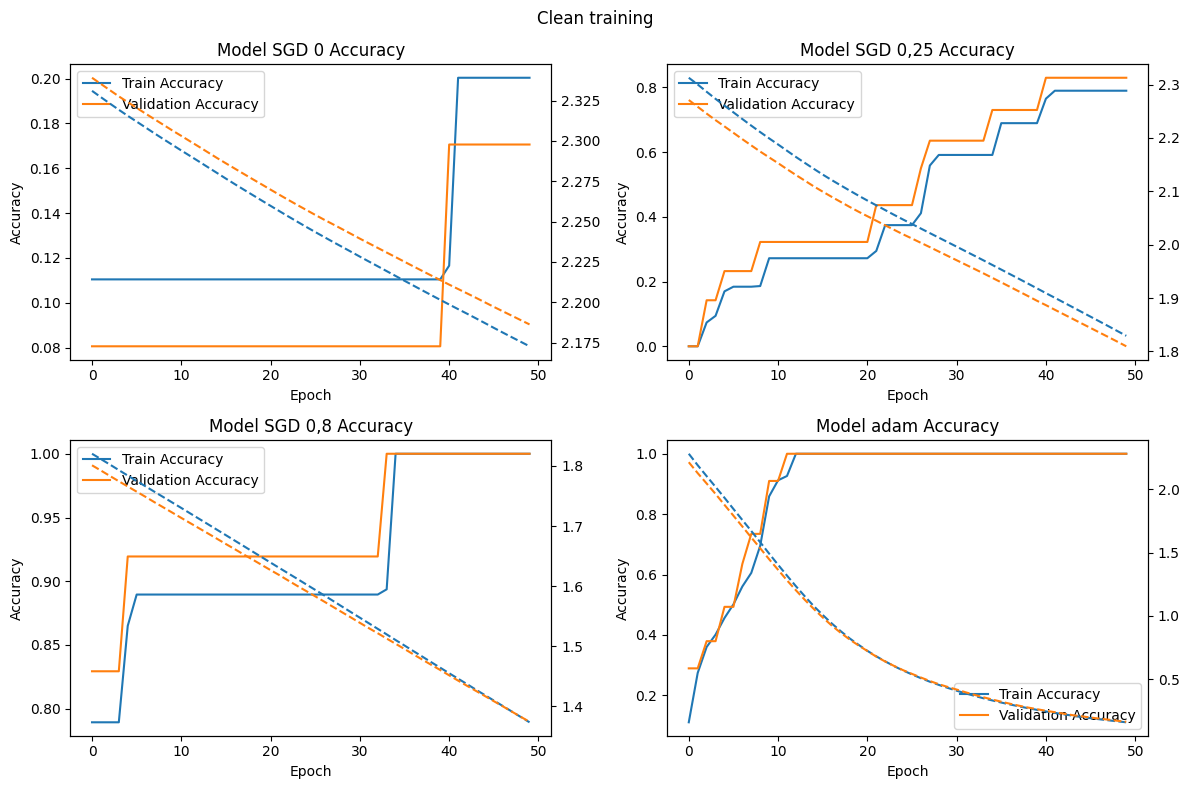

In [67]:
import matplotlib.pyplot as plt

# Assumez que vous avez quatre historiques (history1, history2, history3, history4)

# Création d'une grille 2x2
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
val = ['SGD 0','SGD 0,25','SGD 0,8','adam']

# Boucle pour remplir chaque sous-graphique
for i in range(2):
    for j in range(2):
        idx = i * 2 + j + 1  # Index de l'historique
        ax = axes[i, j]

        # Sélectionnez l'historique correspondant
        history = globals()['history{}'.format(idx)]

        # Train Accuracy vs Validation Accuracy
        ax.plot(history.history['accuracy'], label='Train Accuracy')
        ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Epoch')
        ax.legend()

        # Train Loss vs Validation Loss
        ax = axes[i, j].twinx()  # Créez un axe partagé pour les deux graphiques
        ax.plot(history.history['loss'], linestyle='dashed')
        ax.plot(history.history['val_loss'], linestyle='dashed')
        ax.set_title(f'Model {val[idx-1]} Accuracy')

# Ajustez la mise en page
plt.suptitle('Clean training')
plt.tight_layout()
plt.show()


Prédiction

In [68]:
print(f'Validation sur X_C')
for idx, model in enumerate(models, start=1):
    error = calculate_error(model, X_testC, y_testC)
    print(f'Model {val[idx-1]} Error: {error:.2f}%')
print(f' ')
print(f'Validation sur X_N')
for idx, model in enumerate(models, start=1):
    error = calculate_error(model, X_testN, y_testN)
    print(f'Model {val[idx-1]} Error: {error:.2f}%')

Validation sur X_C
10/10 [==============================] - 0s 2ms/step
Model SGD 0 Error: 78.00%
10/10 [==============================] - 0s 1ms/step
Model SGD 0,25 Error: 100.00%
10/10 [==============================] - 0s 889us/step
Model SGD 0,8 Error: 0.00%
10/10 [==============================] - 0s 944us/step
Model adam Error: 0.00%
 
Validation sur X_N
10/10 [==============================] - 0s 1ms/step
Model SGD 0 Error: 76.00%
10/10 [==============================] - 0s 889us/step
Model SGD 0,25 Error: 100.00%
10/10 [==============================] - 0s 828us/step
Model SGD 0,8 Error: 39.33%
10/10 [==============================] - 0s 1ms/step
Model adam Error: 20.00%


Apprentissage pour X_N

In [69]:
modelMomentum0 = keras.Sequential()
modelMomentum0.add(keras.layers.Input(shape=(12,)))
modelMomentum0.add(keras.layers.Dense(35, activation='relu'))
modelMomentum0.add(keras.layers.Dense(10, activation='softmax'))
modelMomentum0.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

modelMomentum0_25 = keras.Sequential()
modelMomentum0_25.add(keras.layers.Input(shape=(12,)))
modelMomentum0_25.add(keras.layers.Dense(35, activation='relu'))
modelMomentum0_25.add(keras.layers.Dense(10, activation='softmax'))
modelMomentum0_25.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.25), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

modelMomentum0_8 = keras.Sequential()
modelMomentum0_8.add(keras.layers.Input(shape=(12,)))
modelMomentum0_8.add(keras.layers.Dense(35, activation='relu'))
modelMomentum0_8.add(keras.layers.Dense(10, activation='softmax'))
modelMomentum0_8.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.8), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

modelAdam = keras.Sequential()
modelAdam.add(keras.layers.Input(shape=(12,)))
modelAdam.add(keras.layers.Dense(35, activation='relu'))
modelAdam.add(keras.layers.Dense(10, activation='softmax'))
modelAdam.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [70]:
models = [modelMomentum0, modelMomentum0_25, modelMomentum0_8, modelAdam]

In [ ]:
history1 = modelMomentum0.fit(np.array(X_trainN),y_trainN,epochs=50,validation_split=0.3)
history2 = modelMomentum0_8.fit(np.array(X_trainN),y_trainN,epochs=50,validation_split=0.3)
history3 = modelMomentum0_8.fit(np.array(X_trainN),y_trainN,epochs=50,validation_split=0.3)
history4 = modelAdam.fit(np.array(X_trainN),y_trainN,epochs=50,validation_split=0.3)

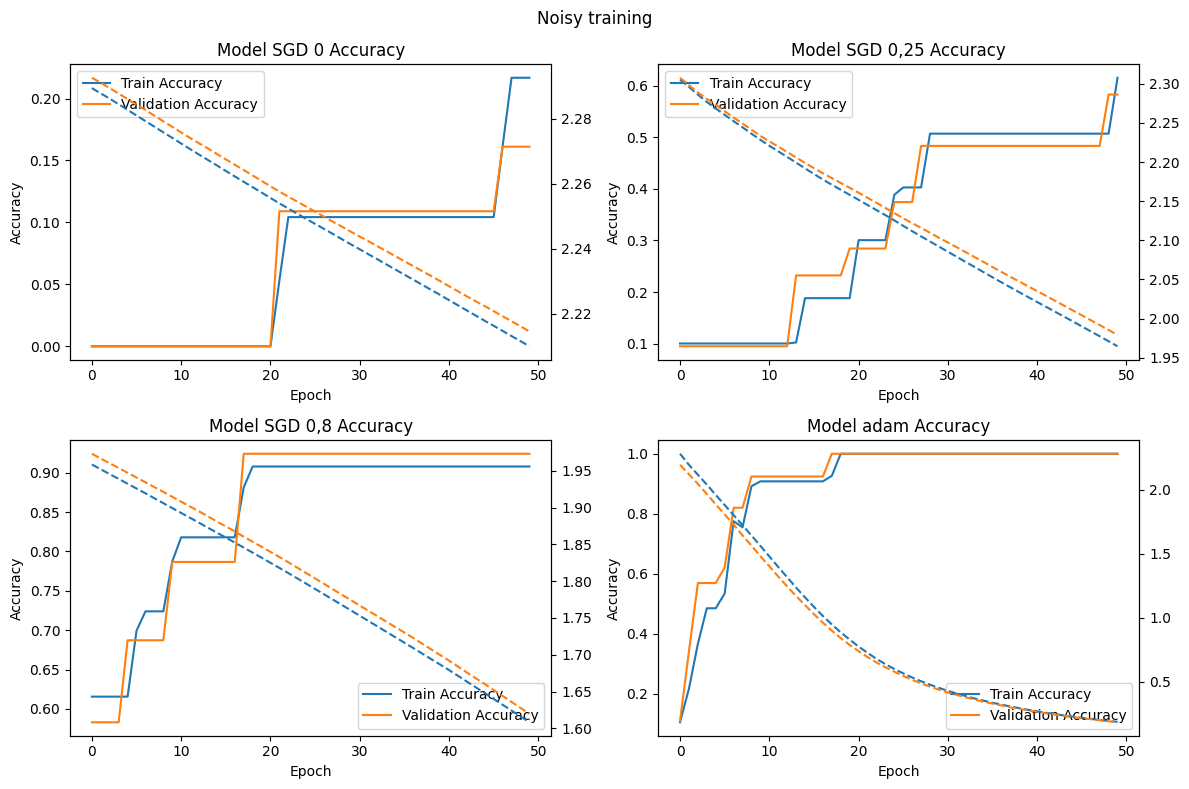

In [72]:
# Création d'une grille 2x2
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
val = ['SGD 0','SGD 0,25','SGD 0,8','adam']

# Boucle pour remplir chaque sous-graphique
for i in range(2):
    for j in range(2):
        idx = i * 2 + j + 1  # Index de l'historique
        ax = axes[i, j]

        # Sélectionnez l'historique correspondant
        history = globals()['history{}'.format(idx)]

        # Train Accuracy vs Validation Accuracy
        ax.plot(history.history['accuracy'], label='Train Accuracy')
        ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Epoch')
        ax.legend()

        # Train Loss vs Validation Loss
        ax = axes[i, j].twinx()  # Créez un axe partagé pour les deux graphiques
        ax.plot(history.history['loss'], linestyle='dashed')
        ax.plot(history.history['val_loss'], linestyle='dashed')
        ax.set_title(f'Model {val[idx-1]} Accuracy')

# Ajustez la mise en page
plt.suptitle('Noisy training')
plt.tight_layout()
plt.show()


Prédiction

In [73]:
print(f'Validation sur X_C')
for idx, model in enumerate(models, start=1):
    error = calculate_error(model, X_testC, y_testC)
    print(f'Model {val[idx-1]} Error: {error:.2f}%')
print(f' ')
print(f'Validation sur X_N')
for idx, model in enumerate(models, start=1):
    error = calculate_error(model, X_testN, y_testN)
    print(f'Model {val[idx-1]} Error: {error:.2f}%')

Validation sur X_C
10/10 [==============================] - 0s 2ms/step
Model SGD 0 Error: 100.00%
10/10 [==============================] - 0s 1ms/step
Model SGD 0,25 Error: 76.67%
10/10 [==============================] - 0s 1ms/step
Model SGD 0,8 Error: 37.33%
10/10 [==============================] - 0s 1ms/step
Model adam Error: 27.67%
 
Validation sur X_N
10/10 [==============================] - 0s 1ms/step
Model SGD 0 Error: 80.00%
10/10 [==============================] - 0s 1ms/step
Model SGD 0,25 Error: 80.67%
10/10 [==============================] - 0s 1ms/step
Model SGD 0,8 Error: 13.00%
10/10 [==============================] - 0s 1ms/step
Model adam Error: 0.00%


Apprentissage pour X_B

In [74]:
modelMomentum0 = keras.Sequential()
modelMomentum0.add(keras.layers.Input(shape=(12,)))
modelMomentum0.add(keras.layers.Dense(35, activation='relu'))
modelMomentum0.add(keras.layers.Dense(10, activation='softmax'))
modelMomentum0.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

modelMomentum0_25 = keras.Sequential()
modelMomentum0_25.add(keras.layers.Input(shape=(12,)))
modelMomentum0_25.add(keras.layers.Dense(35, activation='relu'))
modelMomentum0_25.add(keras.layers.Dense(10, activation='softmax'))
modelMomentum0_25.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.25), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

modelMomentum0_8 = keras.Sequential()
modelMomentum0_8.add(keras.layers.Input(shape=(12,)))
modelMomentum0_8.add(keras.layers.Dense(35, activation='relu'))
modelMomentum0_8.add(keras.layers.Dense(10, activation='softmax'))
modelMomentum0_8.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001,momentum=0.8), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

modelAdam = keras.Sequential()
modelAdam.add(keras.layers.Input(shape=(12,)))
modelAdam.add(keras.layers.Dense(35, activation='relu'))
modelAdam.add(keras.layers.Dense(10, activation='softmax'))
modelAdam.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [75]:
models = [modelMomentum0, modelMomentum0_25, modelMomentum0_8, modelAdam]

In [ ]:
history1 = modelMomentum0.fit(np.array(X_trainB),y_trainB,epochs=50,validation_split=0.3)
history2 = modelMomentum0_8.fit(np.array(X_trainB),y_trainB,epochs=50,validation_split=0.3)
history3 = modelMomentum0_8.fit(np.array(X_trainB),y_trainB,epochs=50,validation_split=0.3)
history4 = modelAdam.fit(np.array(X_trainB),y_trainB,epochs=50,validation_split=0.3)

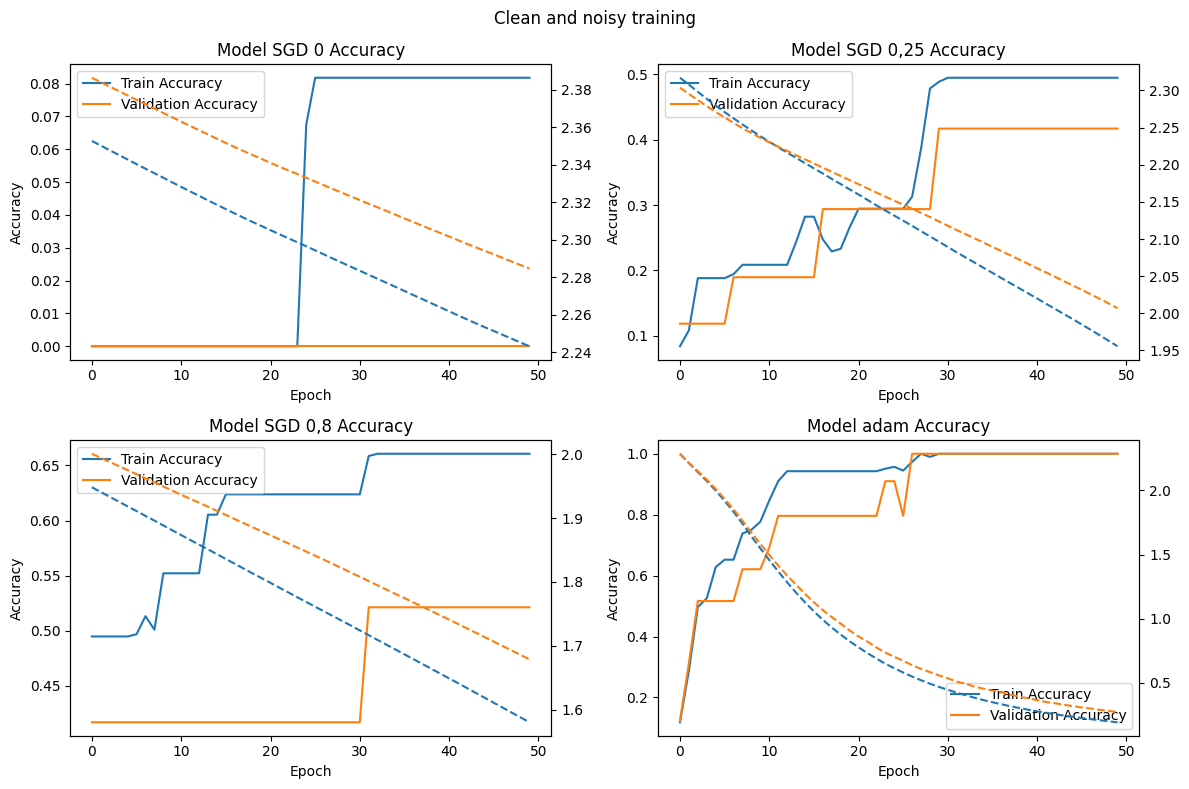

In [77]:
# Création d'une grille 2x2
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
val = ['SGD 0','SGD 0,25','SGD 0,8','adam']

# Boucle pour remplir chaque sous-graphique
for i in range(2):
    for j in range(2):
        idx = i * 2 + j + 1  # Index de l'historique
        ax = axes[i, j]

        # Sélectionnez l'historique correspondant
        history = globals()['history{}'.format(idx)]

        # Train Accuracy vs Validation Accuracy
        ax.plot(history.history['accuracy'], label='Train Accuracy')
        ax.plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Epoch')
        ax.legend()

        # Train Loss vs Validation Loss
        ax = axes[i, j].twinx()  # Créez un axe partagé pour les deux graphiques
        ax.plot(history.history['loss'], linestyle='dashed')
        ax.plot(history.history['val_loss'], linestyle='dashed')
        ax.set_title(f'Model {val[idx-1]} Accuracy')

# Ajustez la mise en page
plt.suptitle('Clean and noisy training')
plt.tight_layout()
plt.show()


Prédiction

In [78]:
print(f'Validation sur X_C')
for idx, model in enumerate(models, start=1):
    error = calculate_error(model, X_testC, y_testC)
    print(f'Model {val[idx-1]} Error: {error:.2f}%')
print(f' ')
print(f'Validation sur X_N')
for idx, model in enumerate(models, start=1):
    error = calculate_error(model, X_testN, y_testN)
    print(f'Model {val[idx-1]} Error: {error:.2f}%')

Validation sur X_C
10/10 [==============================] - 0s 1ms/step
Model SGD 0 Error: 87.67%
10/10 [==============================] - 0s 1ms/step
Model SGD 0,25 Error: 82.00%
10/10 [==============================] - 0s 1ms/step
Model SGD 0,8 Error: 29.67%
10/10 [==============================] - 0s 1ms/step
Model adam Error: 0.00%
 
Validation sur X_N
10/10 [==============================] - 0s 2ms/step
Model SGD 0 Error: 100.00%
10/10 [==============================] - 0s 2ms/step
Model SGD 0,25 Error: 89.67%
10/10 [==============================] - 0s 1ms/step
Model SGD 0,8 Error: 47.67%
10/10 [==============================] - 0s 2ms/step
Model adam Error: 0.00%
